In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [ ]:


from roboflow import Roboflow
rf = Roboflow(api_key="O3OhDtje1VrtLwgW9OJZ")
project = rf.workspace("project-q3v8e").project("traffic_management-1hjbr")
version = project.version(2)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to traffic_management-2 in yolov5pytorch:: 100%|██████████| 13574/13574 [00:02<00:00, 5279.43it/s]


In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16651, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 16651 (delta 81), reused 114 (delta 56), pack-reused 16459
Receiving objects: 100% (16651/16651), 15.36 MiB | 28.75 MiB/s, done.
Resolving deltas: 100% (11384/11384), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.5/783.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Paths
train_images_dir = '/content/traffic_management-2/train/images'
train_labels_dir = '/content/traffic_management-2/train/labels'
augmented_images_dir = '/content/traffic_management-2/train/augmented_images'
augmented_labels_dir = '/content/traffic_management-2/train/augmented_labels'

os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), p=0.5)
])

# Function to apply augmentation
def augment_image(image_path, label_path, output_image_dir, output_label_dir, num_augmentations=5):
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path).replace('.jpg', '')
    label_name = os.path.basename(label_path)
    label = open(label_path, 'r').read()

    for i in range(num_augmentations):
        augmented = transform(image=image)
        augmented_image = augmented['image']
        augmented_image_name = f"{image_name}_aug_{i}.jpg"
        augmented_label_name = f"{image_name}_aug_{i}.txt"

        cv2.imwrite(os.path.join(output_image_dir, augmented_image_name), augmented_image)
        with open(os.path.join(output_label_dir, augmented_label_name), 'w') as f:
            f.write(label)

# Apply augmentation
for img_file in tqdm(os.listdir(train_images_dir)):
    if img_file.startswith('ambulance') and img_file.endswith('.jpg'):
        img_path = os.path.join(train_images_dir, img_file)
        label_path = os.path.join(train_labels_dir, img_file.replace('.jpg', '.txt'))
        augment_image(img_path, label_path, augmented_images_dir, augmented_labels_dir)

print("Data augmentation complete.")


100%|██████████| 5463/5463 [00:00<00:00, 1636794.25it/s]

Data augmentation complete.


In [ ]:
import shutil

# Move augmented images and labels to main training directories
for img_file in os.listdir(augmented_images_dir):
    shutil.move(os.path.join(augmented_images_dir, img_file), os.path.join(train_images_dir, img_file))

for label_file in os.listdir(augmented_labels_dir):
    shutil.move(os.path.join(augmented_labels_dir, label_file), os.path.join(train_labels_dir, label_file))

print("Augmented images and labels moved to training directories.")


Augmented images and labels moved to training directories.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/traffic_management-2/data.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt


2024-06-20 11:36:49.251954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 11:36:49.252001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 11:36:49.371011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/content/traffic_management-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, de

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1: 447x670 1 ambulance, 1 autorickshaw, 5 buss, 15 cars, 1 fire_truck, 2 motorcycles, 4 trucks
Speed: 21.8ms pre-process, 75.0ms inference, 645.4ms NMS per image at shape (1, 3, 448, 640)


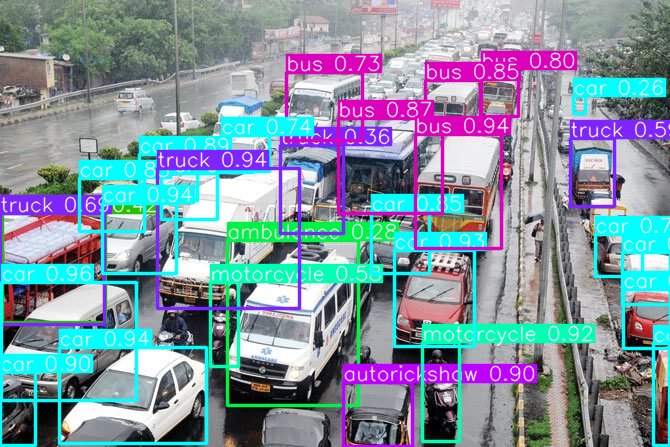

In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt')
model.eval()

# Step 3: Load the image
image_path = '/content/ambulance_img.jpeg'  # Path to the image

# Step 4: Make predictions and display the annotated output
results = model(image_path)
results.print()  # Print the results
results.show()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 
image 1/1: 505x903 2 ambulances, 3 cars, 2 motorcycles
Speed: 26.9ms pre-process, 7.3ms inference, 1.8ms NMS per image at shape (1, 3, 384, 640)


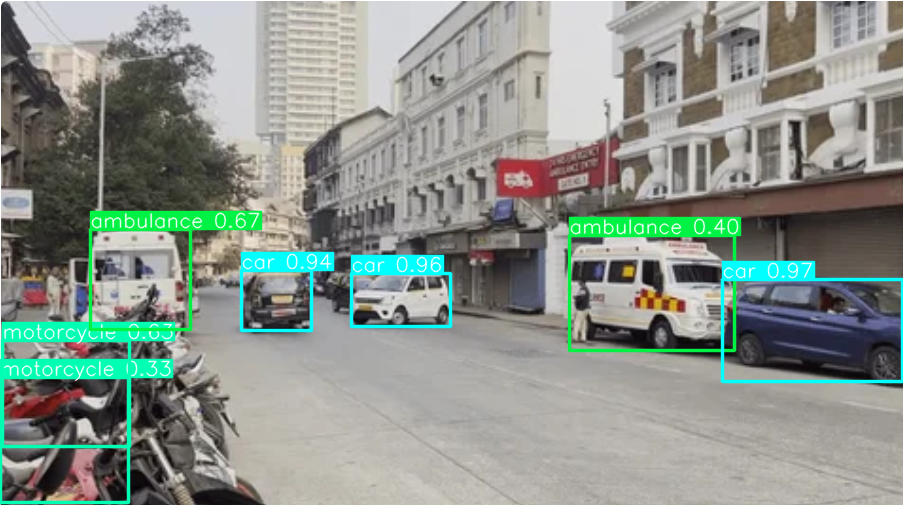

In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt')
model.eval()

# Step 3: Load the image
image_path = '/content/image3.png'  # Path to the image

# Step 4: Make predictions and display the annotated output
results = model(image_path)
results.print()  # Print the results
results.show()

In [ ]:

# Step 2: Load the model
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt')
model.eval()

# Step 3: Process the video
import cv2
import os

# Define the path to the input video
input_video_path = '/content/ambulance.mp4'  # Replace with your video path
output_video_path = '/content/ambulance_output.mp4'

# Open the video file
video_capture = cv2.VideoCapture(input_video_path)

# Get video properties
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
codec = cv2.VideoWriter_fourcc(*'mp4v')

# Define the video writer
video_writer = cv2.VideoWriter(output_video_path, codec, fps, (width, height))

# Process each frame
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    # Convert the frame to the format expected by YOLOv5
    results = model(frame)

    # Get the annotated frame
    annotated_frame = results.render()[0]

    # Write the annotated frame to the output video
    video_writer.write(annotated_frame)

# Release the video capture and writer
video_capture.release()
video_writer.release()

print(f"Annotated video saved to {output_video_path}")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


Annotated video saved to /content/ambulance_output.mp4
